# Kratos example: linear model

In [1]:
from probabilistic_library import ReliabilityProject, ReliabilityMethod, DistributionType, CombineProject, CombineType, CombinerMethod, CompareType
from probabilistic_library import UncertaintyProject, UncertaintyMethod, Stochast, StartMethod, RunProject, RunValuesType

### Model

In [2]:
from run_kratos_quay_wall import zfuncwrapper_linear

### Variables

In [3]:
def define_project_variables(project):

    use_correlations = False
    project.variables["geo_young_modulus"].is_array = True
    if use_correlations:
        project.variables["geo_young_modulus"].array_size = 2
        maxNrClays = 0
    else:
        project.variables["geo_young_modulus"].array_size = 7
        maxNrClays = 3

    for i in range(project.variables["geo_young_modulus"].array_size):
        young_modulus = Stochast()
        if i <= maxNrClays: # Clays with low-medium plasticity, medium
            young_modulus.distribution = DistributionType.uniform
            young_modulus.minimum = 5E6
            young_modulus.maximum = 8E6
        else: # Sand, uniform, medium
            young_modulus.distribution = DistributionType.deterministic
            young_modulus.mean = 40E6
        project.variables["geo_young_modulus"].array_variables.append(young_modulus)

    project.variables["interface_stiffness"].distribution = DistributionType.deterministic
    project.variables["interface_stiffness"].is_array = True
    project.variables["interface_stiffness"].array_size = 6
    project.variables["interface_stiffness"].mean = 10**11 # value checked

    project.variables["sheetpile_young_modulus"].distribution = DistributionType.deterministic
    project.variables["sheetpile_young_modulus"].is_array = True
    project.variables["sheetpile_young_modulus"].array_size = 1
    project.variables["sheetpile_young_modulus"].mean = 200E9 # value checked

    project.variables["sheetpile_poisson_ratio"].distribution = DistributionType.deterministic
    project.variables["sheetpile_poisson_ratio"].is_array = True
    project.variables["sheetpile_poisson_ratio"].array_size = 1
    project.variables["sheetpile_poisson_ratio"].mean = 0.0 # value checked

    project.variables["sheetpile_thickness"].distribution = DistributionType.deterministic
    project.variables["sheetpile_thickness"].is_array = True
    project.variables["sheetpile_thickness"].array_size = 1
    project.variables["sheetpile_thickness"].mean = 0.02159 # value checked

    return project

### Uncertainty analysis (total displacement x, surface level)

In [ ]:
output_stage = [3]

for val in output_stage:

    project = UncertaintyProject()
    wrapper = zfuncwrapper_linear(output_stage_number = val, clean_up = True)
    project.model = wrapper.total_displacement

    project = define_project_variables(project)

    project.settings.uncertainty_method = UncertaintyMethod.crude_monte_carlo
    project.settings.variation_coefficient = 0.02
    project.settings.minimum_samples = 50
    project.settings.maximum_samples = 100
    project.settings.save_convergence = True
    project.settings.save_realizations = True
    project.settings.max_parallel_processes = 1

    project.run()

    project.stochast.plot()

### Uncertainty analysis (max bending moment)

In [ ]:
output_stage = [3] 

for val in output_stage:

    project = UncertaintyProject()
    wrapper = zfuncwrapper_linear(output_stage_number = val, clean_up = True)
    project.model = wrapper.max_bending_moment

    project = define_project_variables(project)

    project.settings.uncertainty_method = UncertaintyMethod.crude_monte_carlo
    project.settings.variation_coefficient = 0.02
    project.settings.minimum_samples = 50
    project.settings.maximum_samples = 100
    project.settings.save_convergence = True
    project.settings.save_realizations = True

    project.run()

    project.stochast.plot()

### Reliability analysis (total displacement x, surface level)

In [4]:
project = ReliabilityProject()
wrapper = zfuncwrapper_linear(output_stage_number = 3, clean_up = True)
project.model = wrapper.total_displacement
project = define_project_variables(project)

In [5]:
project.settings.reliability_method = ReliabilityMethod.form
project.settings.variation_coefficient = 0.02
project.settings.maximum_iterations = 50
project.settings.start_method = StartMethod.sensitivity_search
project.settings.save_convergence = True
project.settings.save_realizations = True

project.limit_state_function.compare_type = CompareType.less_than
project.limit_state_function.parameter = project.model.output_parameters[0]
critical_values = [-0.1, -0.15, -0.17, -0.19]

for val in critical_values:
    project.limit_state_function.critical_value = val

    project.run()

    print(f"critical value = {val}")
    print(f"faalkans = {project.design_point.probability_failure}")
    print(f"beta = {project.design_point.reliability_index}")

    dp1 = project.design_point

critical value = -0.1
faalkans = 1.0
beta = -81.21337769098491
critical value = -0.15
faalkans = 0.5555238962499007
beta = -0.13963016293380898
critical value = -0.17
faalkans = 0.23718736687184133
beta = 0.7153792450243154
critical value = -0.19
faalkans = 0.022931059850376054
beta = 1.9966600962970156


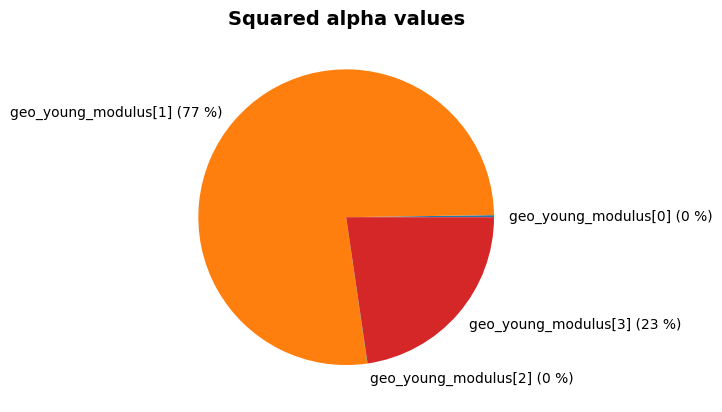

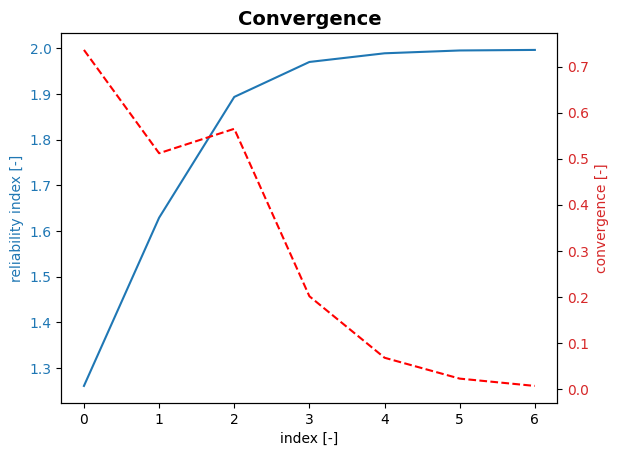

In [6]:
dp1.plot_alphas()
dp1.plot_convergence()

### Reliability analysis (max bending moment)

In [7]:
wrapper = zfuncwrapper_linear(output_stage_number = 3, clean_up = True)
project.model = wrapper.max_bending_moment

project.settings.reliability_method = ReliabilityMethod.form
project.settings.variation_coefficient = 0.02
project.settings.start_method = StartMethod.sensitivity_search
project.settings.maximum_iterations = 50
project.settings.save_convergence = True
project.settings.save_realizations = True

project.limit_state_function.compare_type = CompareType.greater_than
project.limit_state_function.parameter = project.model.output_parameters[0]
critical_values = [20000, 30000, 40000]

for val in critical_values:

    project.limit_state_function.critical_value = val

    project.run()

    print(f"critical value = {val}")
    print(f"faalkans = {project.design_point.probability_failure}")
    print(f"beta = {project.design_point.reliability_index}")

    dp2 = project.design_point

critical value = 20000
faalkans = 0.27481598663658363
beta = 0.5983116969482112
critical value = 30000
faalkans = 0.17470211219050744
beta = 0.9357455263081604
critical value = 40000
faalkans = 0.09020219195564375
beta = 1.3395109752643086


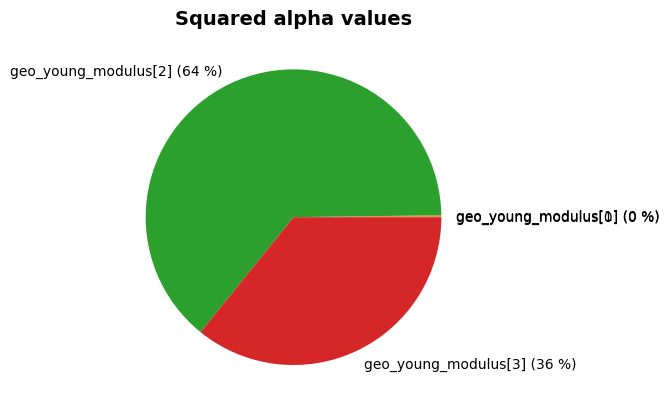

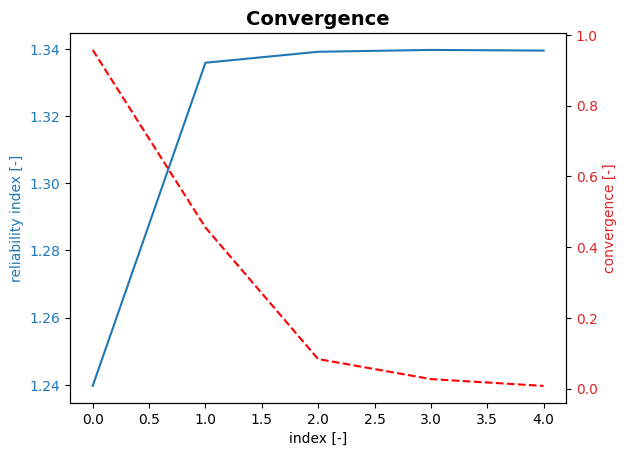

In [8]:
dp2.plot_alphas()
dp2.plot_convergence()

### Combine probabilities

In [9]:
combine_project = CombineProject()

combine_project.design_points.append(dp1)
combine_project.design_points.append(dp2)

combine_project.settings.combine_type = CombineType.series
combine_project.settings.combiner_method = CombinerMethod.hohenbichler_form

combine_project.run()

combine_project.design_point.print()

Reliability:
 Reliability index = 1.213
 Probability of failure = 0.1125
 Model runs = 0
Alpha values:
 geo_young_modulus[0]: alpha = -0.01131, x = 6.516e+06
 geo_young_modulus[1]: alpha = 0.335, x = 6.027e+06
 geo_young_modulus[2]: alpha = 0.8288, x = 5.472e+06
 geo_young_modulus[3]: alpha = -0.4481, x = 7.12e+06
 geo_young_modulus[4]: alpha = 0, x = 4e+07
 geo_young_modulus[5]: alpha = 0, x = 4e+07
 geo_young_modulus[6]: alpha = 0, x = 4e+07
 interface_stiffness[0]: alpha = 0, x = 1e+11
 interface_stiffness[0]: alpha = 0, x = 1e+11
 interface_stiffness[0]: alpha = 0, x = 1e+11
 interface_stiffness[0]: alpha = 0, x = 1e+11
 interface_stiffness[0]: alpha = 0, x = 1e+11
 interface_stiffness[0]: alpha = 0, x = 1e+11
 sheetpile_young_modulus[0]: alpha = 0, x = 2e+11
 sheetpile_poisson_ratio[0]: alpha = 0, x = 0
 sheetpile_thickness[0]: alpha = 0, x = 0.02159



### Rerun model with final design point

In [ ]:
project = RunProject()
wrapper = zfuncwrapper_linear(output_stage_number = 3, clean_up = False)
project.model = wrapper.total_displacement
define_project_variables(project)
# note: only the first 4 values are different from the mean_values
for i in range(4):
    project.variables["geo_young_modulus"].array_variables[i].mean = combine_project.design_point.alphas[i].x

project.settings.run_values_type = RunValuesType.mean_values
project.run()